In [1]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 
from math import *

# 05/09/2025

# Continuing the examination of the PKPD curves of different weight groups to figure out where the bug is

<br>

---

<br>

# Objective 1: Adjusted PD <= 10^(-5) = 0; Checking if that improves efficacy across weights
<br>

---
    
# Using previously calibrated --pmax_artemether 0.9999994 and --ec50_lum 64 values

--- 

<br>

### Generating list of weights 

In [2]:
# Define the range for weight_art
min_weight = 1
max_weight = 75

# Define weight_art values
weight_values = np.linspace(min_weight, max_weight, 75)  # 50 values between 0.99997 and 0.8

# Initialize a grid to store the clearance rates
clearance_rates = np.zeros(len(weight_values))

print(weight_values)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72.
 73. 74. 75.]


### Function call to check efficacy across weight groups

In [3]:
def run_simulation_art_weight_adj(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "5000",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "64",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame(
            [line.split() for line in lines_weight],
            columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"]
        )

        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[df_weight['PARASITEDENSITY'] >= 10].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy, df_weight)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}Kg: {e}")
        return (idx, np.nan, None)  # Return 3 values: idx, NaN for efficacy, and None for DataFrame

In [4]:
for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        killing_constant_file_artemether = f"parasite_killing_constant_{weight}kg_artemether.txt"
        if os.path.isfile(killing_constant_file_artemether):
                os.remove(killing_constant_file_artemether)

        killing_constant_file_lumefantrine = f"parasite_killing_constant_{weight}kg_lumefantrine.txt"
        if os.path.isfile(killing_constant_file_lumefantrine):
                os.remove(killing_constant_file_lumefantrine)


# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
results = []
dfs = []
with Pool(processes=num_workers) as pool:
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation_art_weight_adj, params_list):
            idx, efficacy, df_weight = result
            results.append((idx, efficacy, df_weight))
            if df_weight is not None:
                dfs.append(df_weight)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy, df_weight in results:
    clearance_rates[idx] = efficacy

# Create a DataFrame with weight_values and clearance_rates
df = pd.DataFrame({
    'Weight': weight_values,
    'efficacy': clearance_rates
})

# Save the DataFrame to a pickle file
df.to_pickle("pkpd_AL_weight_vs_efficacy_10_(-5).pyobj")

# Save all individual DataFrames to a single pickle file
df_all = pd.concat(dfs, ignore_index=True)
df_all.to_pickle("pkpd_AL_weight_vs_efficacy_results_10_(-5).pyobj")

# Save the efficacy DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_vs_efficacy_results_10_(-5).csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 75/75 [20:41<00:00, 16.56s/it]    

DataFrame saved as pickle and CSV files successfully.


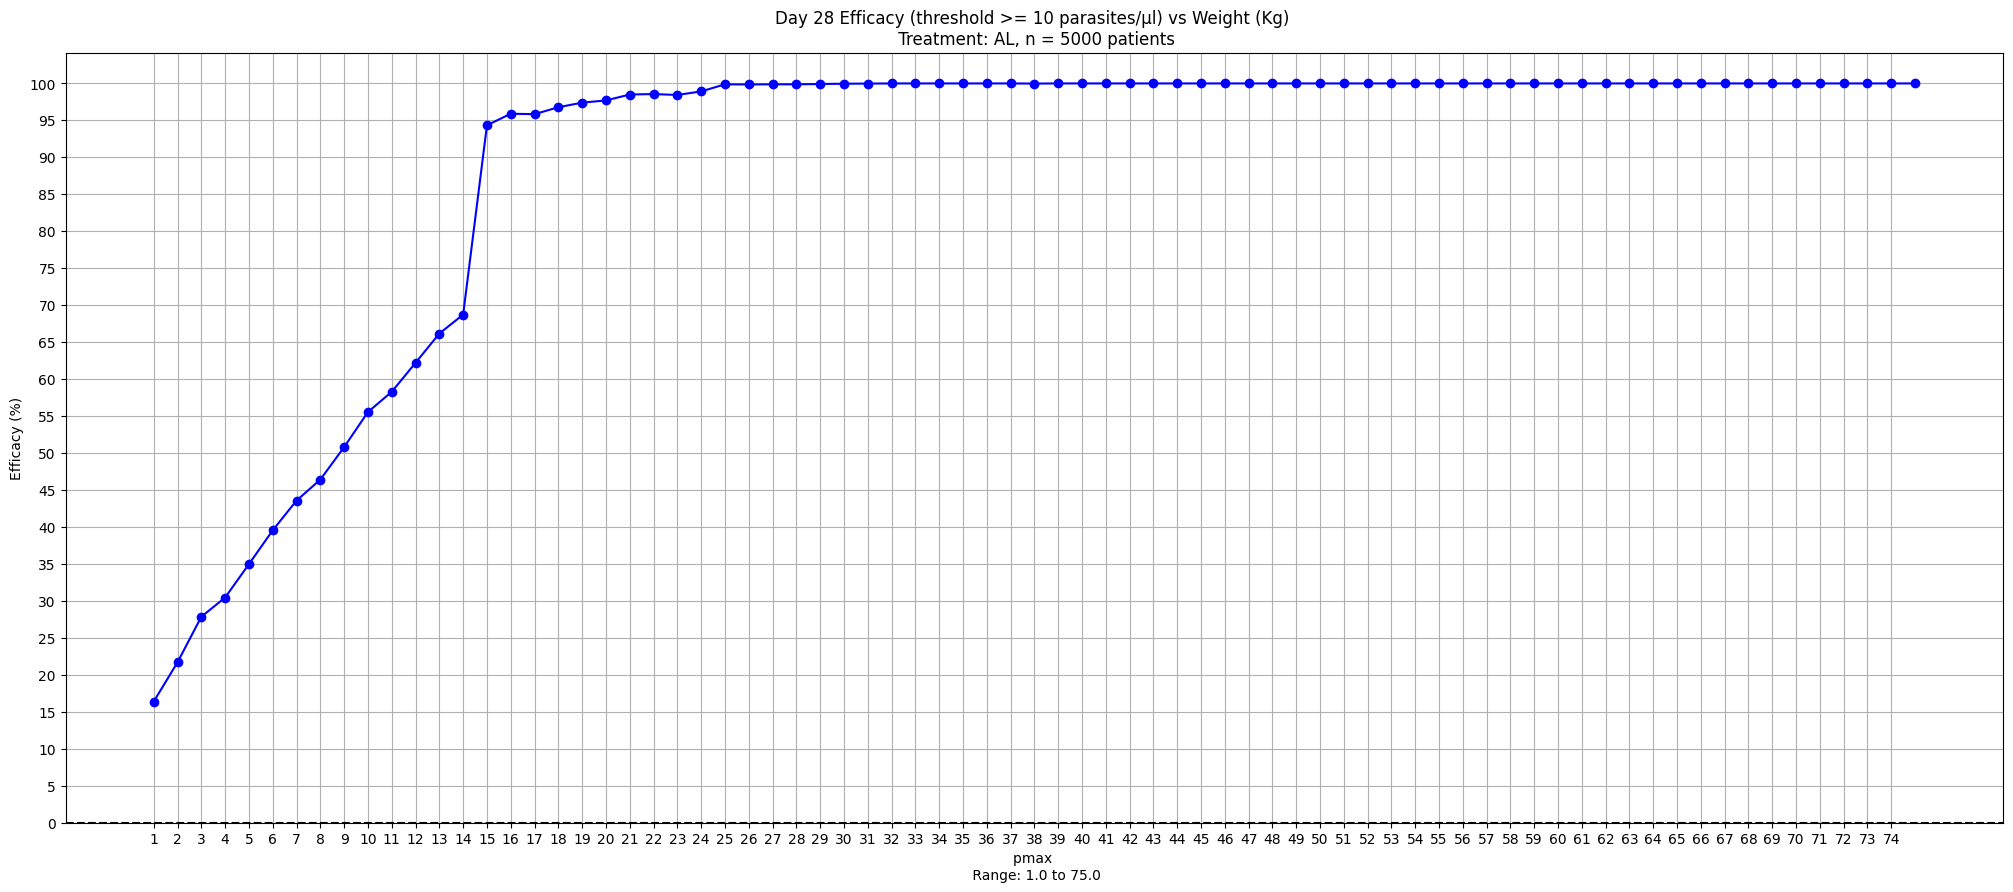

In [5]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, clearance_rates, marker='o', linestyle='-', color='b')
plt.xlabel(f'pmax \n Range: {min(weight_values)} to {max(weight_values)}')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl) vs Weight (Kg) \n Treatment: AL, n = 5000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values), 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_vs_efficacy_results_10_(-5).png")  # Save the plot as a PNG file
plt.show()

### Function call to examine state values of one weight group

In [8]:
# Function to run a single simulation for a given weight value

def run_single_weight_simulation(weight):
    start_time = time.monotonic()
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "1000",
        "--pmax_artemether", "0.9999994",
        "--ec50_lum", "64",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split() for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ARTEMETHER", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        
        end_time = time.monotonic()
        today = datetime.date.today()
        print("\nToday's date: ", today, "\n")
        print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

        return efficacy, df_weight, failed_treatment_count
        
    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

### Weight: 10 Kg

In [9]:
# Define the weight values to use
weight_values = [10, 15, 20, 30, 40, 50]

#weight_values = [10]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        killing_constant_file_artemether = f"parasite_killing_constant_{weight}kg_artemether.txt"
        if os.path.isfile(killing_constant_file_artemether):
                os.remove(killing_constant_file_artemether)

        killing_constant_file_lumefantrine = f"parasite_killing_constant_{weight}kg_lumefantrine.txt"
        if os.path.isfile(killing_constant_file_lumefantrine):
                os.remove(killing_constant_file_lumefantrine)
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")



Today's date:  2025-05-09 

Length of simulation:  0:00:27.377349 


The failed treatment count for weight 10kg is: 103

The percentage efficacy for weight 10kg is: 89.7 


Today's date:  2025-05-09 

Length of simulation:  0:00:31.255034 


The failed treatment count for weight 15kg is: 2

The percentage efficacy for weight 15kg is: 99.8 


Today's date:  2025-05-09 

Length of simulation:  0:00:29.760453 


The failed treatment count for weight 20kg is: 1

The percentage efficacy for weight 20kg is: 99.9 


Today's date:  2025-05-09 

Length of simulation:  0:00:28.197007 


The failed treatment count for weight 30kg is: 0

The percentage efficacy for weight 30kg is: 100.0 


Today's date:  2025-05-09 

Length of simulation:  0:00:29.547959 


The failed treatment count for weight 40kg is: 0

The percentage efficacy for weight 40kg is: 100.0 


Today's date:  2025-05-09 

Length of simulation:  0:00:29.480641 


The failed treatment count for weight 50kg is: 0

The percentage effica

<br>

### Weight: 20 Kg

In [23]:
weight_values = [20]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


Today's date:  2025-04-29 

Length of simulation:  0:00:13.424616 


The failed treatment count for weight 20kg is: 223

The percentage efficacy for weight 20kg is: 55.4 



<br>

### Weight: 30 Kg

In [24]:
weight_values = [30]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


Today's date:  2025-04-29 

Length of simulation:  0:00:13.474891 


The failed treatment count for weight 30kg is: 100

The percentage efficacy for weight 30kg is: 80.0 



<br>

### Weight: 40 Kg

In [25]:
weight_values = [40]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


Today's date:  2025-04-29 

Length of simulation:  0:00:12.440551 


The failed treatment count for weight 40kg is: 32

The percentage efficacy for weight 40kg is: 93.6 



In [26]:
weight_values = [50]

for weight in weight_values:

        params_file_artemether = f"PK_parameters_{weight}kg_artemether.txt"
        if os.path.isfile(params_file_artemether):
                os.remove(params_file_artemether)

        params_file_lumefantrine = f"PK_parameters_{weight}kg_lumefantrine.txt"
        if os.path.isfile(params_file_lumefantrine):
                os.remove(params_file_lumefantrine)
        
        efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)
        
        # Save the DataFrame to a pickle file
        df_weight.to_pickle(f"df_weight_{weight}kg.pyobj")

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_{weight}kg.csv", index=False)
        print(f"\nThe failed treatment count for weight {weight}kg is:", failed_treatment_count)
        print(f"\nThe percentage efficacy for weight {weight}kg is:", efficacy, "\n")


Today's date:  2025-04-29 

Length of simulation:  0:00:14.023591 


The failed treatment count for weight 50kg is: 23

The percentage efficacy for weight 50kg is: 95.4 



In [11]:
# Load the dataframes
# Calculate the efficacy for each weight group

failed_treatment_count = []
efficacy = []
df_weight_compiled = []

for weight in [10, 20, 30, 40, 50]:
    # Load the dataframe
    df_weight = pd.read_pickle(f"df_weight_{weight}kg.pyobj")
    # Calculate the efficacy
    failed_treatment_count.append(df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0])
    total_patients = df_weight['PID'].nunique()
    efficacy.append((1 - (failed_treatment_count[-1] / total_patients)) * 100 if total_patients > 0 else np.nan)
    # Append the dataframe to the list
    df_weight_compiled.append(df_weight)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Weight': [10, 20, 30, 40, 50],
    'Failed Treatment Count': failed_treatment_count,
    'Efficacy': efficacy
})

# Save the results to a CSV file
results_df.to_csv("efficacy_results_compiled_01.csv", index=False)
# Save the results to a pickle file
results_df.to_pickle("efficacy_results_compiled_01.pyobj")
# Print the results
print("\nEfficacy Results:")
print(results_df)
 


Efficacy Results:
   Weight  Failed Treatment Count  Efficacy
0      10                     103      89.7
1      20                       1      99.9
2      30                       0     100.0
3      40                       0     100.0
4      50                       0     100.0


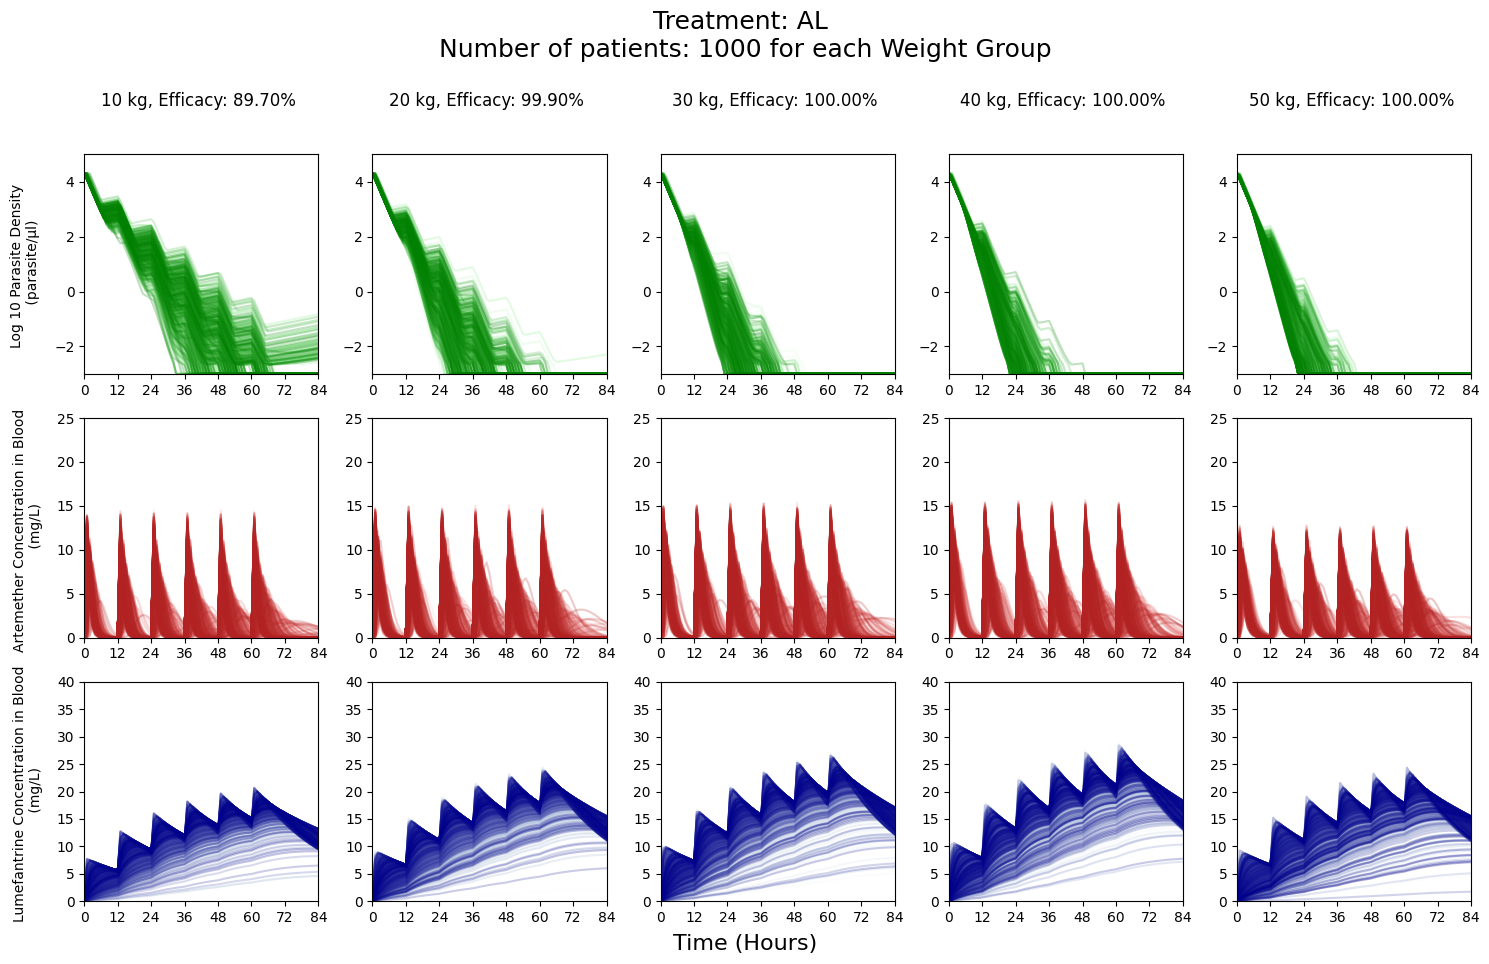

In [12]:
import math
from matplotlib.colors import LinearSegmentedColormap

if len(df_weight_compiled) >= 5:
    df_dict = {10: df_weight_compiled[0], 20: df_weight_compiled[1], 30: df_weight_compiled[2], 40: df_weight_compiled[3], 50: df_weight_compiled[4]}
else:
    print("Error: df_weight_compiled does not have enough elements.")

# Create a 4x3 subplot (3 variables, 5 weightgroups)
fig, ax = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=False)

# Define colormaps for each plot
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["white", "lightgreen", "green"])  # Softer green for Parasite Density
red_cmap = LinearSegmentedColormap.from_list("red_cmap", ["white", "lightcoral", "firebrick"])  # Softer red for Artemether
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["white", "lightsteelblue", "darkblue"])  # Softer blue for Lumefantrine

# Iterate over weight groups
for i, weight in enumerate([10, 20, 30, 40, 50]):
    df_weight = df_dict[weight]  # Get the correct dataframe
    num_pids = len(df_weight['PID'].unique())  # Number of unique PIDs
    norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize colormap

    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid].copy()
        df_pid['LOG10_PARASITEDENSITY'] = np.log10(df_pid['PARASITEDENSITY'] + 0.001)
        color = green_cmap(norm(j))
        ax[0, i].plot(df_pid['HOUR'], df_pid['LOG10_PARASITEDENSITY'], color=color, alpha=0.25)
        ax[0, i].set_ylim(-3, 5)  # Set y-axis limits for Parasite Density

  
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = red_cmap(norm(j))
        ax[1, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_ARTEMETHER'], color=color, alpha=0.25)
        ax[1, i].set_ylim(0, 25)
        ax[2, i].set_yticks(range(0, 30, 5)) 

    # Plot Lumefantrine Concentration (Row 3) with blue colormap
    for j, pid in enumerate(df_weight['PID'].unique()):
        df_pid = df_weight[df_weight['PID'] == pid]
        color = blue_cmap(norm(j))
        ax[2, i].plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
        ax[2, i].set_ylim(0, 40)
        ax[2, i].set_yticks(range(0, 45, 5))  
    

    # Set x-axis limits
    for j in range(3):  # Iterate over rows (0, 1, 2)
        ax[j, i].set_xlim(0, 3*24)
        ax[j, i].set_xticks(range(0, 4*24, 12))

    # Set row labels on the top row
    ax[0, i].set_title(f'{weight} kg, Efficacy: {results_df[results_df["Weight"] == weight]["Efficacy"].values[0]:.2f}% \n ', fontsize=12, pad=20)

# Set **row titles** (only for the leftmost column)
row_titles = ["Log 10 Parasite Density \n (parasite/μl)", "Artemether Concentration in Blood \n (mg/L)", "Lumefantrine Concentration in Blood \n (mg/L)"]
for j in range(3):
    ax[j, 0].set_ylabel(row_titles[j], fontsize=10, rotation=90, labelpad=10)

# Set x-ticks for all subplots
for i in range(3):  
    for j in range(5):
        ax[i, j].tick_params(labelbottom=True)

fig.text(0.5, 0.04, 'Time (Hours)', ha='center', fontsize=16)

fig.suptitle(f"Treatment: AL \nNumber of patients: {num_pids} for each Weight Group", fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust layout to fit common x-label
plt.savefig("df_weight_all_params_all_weights_log10_multicolour_lum_patient_blood_volume_02.png")
plt.show()


In [30]:
pk_params_dfs_artemether = []

for i in range(1, 6):
    pk_params = pd.read_csv(f"PK_parameters_{i}0kg_artemether.txt", sep=",", header=0)
    pk_params_dfs_artemether.append(pk_params)

In [31]:
pk_params_dfs_lumefantrine = []

for i in range(1, 6):
    pk_params = pd.read_csv(f"PK_parameters_{i}0kg_lumefantrine.txt", sep=",", header=0)
    pk_params_dfs_lumefantrine.append(pk_params)

In [32]:
for i in range(0, 5):
    pk_params_dfs_artemether[i].columns = pk_params_dfs_artemether[i].columns.str.replace(' ', '')
    pk_params_dfs_artemether[i].columns = pk_params_dfs_artemether[i].columns.str.replace('/', '_')

    pk_params_dfs_lumefantrine[i].columns = pk_params_dfs_lumefantrine[i].columns.str.replace(' ', '')
    pk_params_dfs_lumefantrine[i].columns = pk_params_dfs_lumefantrine[i].columns.str.replace('/', '_')

In [33]:
pk_params_dfs_lumefantrine[0].columns

Index(['PID', 'i_lum_F1_indiv', 'i_lum_k12(KA)', 'i_lum_k23(Q_V)',
       'i_lum_k32(Q_VP)', 'i_lum_k20(CL_V)', 'total_mg_dose_per_occassion',
       'DS', 'Q', 'V', 'CL', 'VP'],
      dtype='object')

In [34]:
pk_params_dfs_artemether[0].columns

Index(['PID', 'i_artemether_F1_indiv', 'i_artemether_KTR',
       'total_mg_dose_per_occassion', 'TVCL', 'CL', 'TVV2', 'V2',
       'i_artemether_k20(CL_V2)'],
      dtype='object')

In [35]:
artemether_v2_mean = []
artemether_v2_min = []
artemether_v2_max = []
artemether_v2_median = []

for i in range(5):
    artemether_v2_median.append(pk_params_dfs_artemether[i]['V2'].median())
    artemether_v2_mean.append(pk_params_dfs_artemether[i]['V2'].mean())
    artemether_v2_min.append(pk_params_dfs_artemether[i]['V2'].min())
    artemether_v2_max.append(pk_params_dfs_artemether[i]['V2'].max())

print("Artemether V2 Median: ", artemether_v2_median)
print("Artemether V2 Mean: ", artemether_v2_mean)
print("Artemether V2 Min: ", artemether_v2_min)
print("Artemether V2 Max: ", artemether_v2_max)

Artemether V2 Median:  [np.float64(26.47335), np.float64(53.4781), np.float64(80.07705), np.float64(106.7515), np.float64(131.108)]
Artemether V2 Mean:  [np.float64(26.729965800000002), np.float64(54.155968200000004), np.float64(80.5240974), np.float64(107.639669), np.float64(132.63835759999998)]
Artemether V2 Min:  [np.float64(18.1449), np.float64(39.4168), np.float64(53.5975), np.float64(71.9354), np.float64(85.9403)]
Artemether V2 Max:  [np.float64(39.6471), np.float64(74.8673), np.float64(115.028), np.float64(153.669), np.float64(195.918)]


In [36]:
artemether_k20_mean = []
lumefantrine_k23_mean = []
lumefantrine_k20_mean = []
for i in range(5):
    artemether_k20_mean.append(pk_params_dfs_artemether[i]["i_artemether_k20(CL_V2)"].mean())
    lumefantrine_k23_mean.append(pk_params_dfs_lumefantrine[i]["i_lum_k23(Q_V)"].mean())
    lumefantrine_k20_mean.append(pk_params_dfs_lumefantrine[i]["i_lum_k20(CL_V)"].mean())

artemether_k20_min = []
lumefantrine_k23_min = []
lumefantrine_k20_min = []
for i in range(5):
    artemether_k20_min.append(pk_params_dfs_artemether[i]["i_artemether_k20(CL_V2)"].min())
    lumefantrine_k23_min.append(pk_params_dfs_lumefantrine[i]["i_lum_k23(Q_V)"].min())
    lumefantrine_k20_min.append(pk_params_dfs_lumefantrine[i]["i_lum_k20(CL_V)"].min())

artemether_k20_max = []
lumefantrine_k23_max = []
lumefantrine_k20_max = []
for i in range(5):
    artemether_k20_max.append(pk_params_dfs_artemether[i]["i_artemether_k20(CL_V2)"].max())
    lumefantrine_k23_max.append(pk_params_dfs_lumefantrine[i]["i_lum_k23(Q_V)"].max())
    lumefantrine_k20_max.append(pk_params_dfs_lumefantrine[i]["i_lum_k20(CL_V)"].max())

artemether_k20_median = []
lumefantrine_k23_median = []
lumefantrine_k20_median = []

for i in range(5):
    artemether_k20_median.append(pk_params_dfs_artemether[i]["i_artemether_k20(CL_V2)"].median())
    lumefantrine_k23_median.append(pk_params_dfs_lumefantrine[i]["i_lum_k23(Q_V)"].median())
    lumefantrine_k20_median.append(pk_params_dfs_lumefantrine[i]["i_lum_k20(CL_V)"].median())   



In [37]:
lumefantrine_k32_mean = []
lumefantrine_k32_min = []
lumefantrine_k32_max = []
lumefantrine_k32_median = []

for i in range(0, 5):
    lumefantrine_k32_mean.append(pk_params_dfs_lumefantrine[i]["i_lum_k32(Q_VP)"].mean())
    lumefantrine_k32_min.append(pk_params_dfs_lumefantrine[i]["i_lum_k32(Q_VP)"].min())
    lumefantrine_k32_max.append(pk_params_dfs_lumefantrine[i]["i_lum_k32(Q_VP)"].max())
    lumefantrine_k32_median.append(pk_params_dfs_lumefantrine[i]["i_lum_k32(Q_VP)"].median())

print("Lumefantrine k32 mean values: ", lumefantrine_k32_mean)
print("Lumefantrine k32 min values: ", lumefantrine_k32_min)
print("Lumefantrine k32 max values: ", lumefantrine_k32_max)
print("Lumefantrine k32 median values: ", lumefantrine_k32_median)

Lumefantrine k32 mean values:  [np.float64(0.00834678), np.float64(0.007018769999999998), np.float64(0.006342180000000002), np.float64(0.00590206), np.float64(0.005581830000000001)]
Lumefantrine k32 min values:  [np.float64(0.00834678), np.float64(0.00701877), np.float64(0.00634218), np.float64(0.00590206), np.float64(0.00558183)]
Lumefantrine k32 max values:  [np.float64(0.00834678), np.float64(0.00701877), np.float64(0.00634218), np.float64(0.00590206), np.float64(0.00558183)]
Lumefantrine k32 median values:  [np.float64(0.00834678), np.float64(0.00701877), np.float64(0.00634218), np.float64(0.00590206), np.float64(0.00558183)]


In [38]:
for i in range(0, 5):
    print(f"\n\n\n\nArtemether k20 mean for weight {i+1}0kg: {artemether_k20_mean[i]}")
    print(f"Artemether k20 min for weight {i+1}0kg: {artemether_k20_min[i]}")
    print(f"Artemether k20 max for weight {i+1}0kg: {artemether_k20_max[i]}")
    print(f"Artemether k20 median for weight {i+1}0kg: {artemether_k20_median[i]}\n")


    print(f"\nLumefantrine k23 mean for weight {i+1}0kg: {lumefantrine_k23_mean[i]}")
    print(f"Lumefantrine k23 min for weight {i+1}0kg: {lumefantrine_k23_min[i]}")
    print(f"Lumefantrine k23 max for weight {i+1}0kg: {lumefantrine_k23_max[i]}")
    print(f"Lumefantrine k23 median for weight {i+1}0kg: {lumefantrine_k23_median[i]}\n")


    print(f"\nLumefantrine k20 mean for weight {i+1}0kg: {lumefantrine_k20_mean[i]}")
    print(f"Lumefantrine k20 min for weight {i+1}0kg: {lumefantrine_k20_min[i]}")
    print(f"Lumefantrine k20 max for weight {i+1}0kg: {lumefantrine_k20_max[i]}")
    print(f"Lumefantrine k20 median for weight {i+1}0kg: {lumefantrine_k20_median[i]}\n")





Artemether k20 mean for weight 10kg: 0.9079584660000001
Artemether k20 min for weight 10kg: 0.601973
Artemether k20 max for weight 10kg: 1.31532
Artemether k20 median for weight 10kg: 0.901528


Lumefantrine k23 mean for weight 10kg: 0.07683987582
Lumefantrine k23 min for weight 10kg: 0.00196553
Lumefantrine k23 max for weight 10kg: 1.54412
Lumefantrine k23 median for weight 10kg: 0.046075450000000004


Lumefantrine k20 mean for weight 10kg: 0.30155181835999995
Lumefantrine k20 min for weight 10kg: 0.00771356
Lumefantrine k20 max for weight 10kg: 6.05979
Lumefantrine k20 median for weight 10kg: 0.1808195





Artemether k20 mean for weight 20kg: 0.752753334
Artemether k20 min for weight 20kg: 0.536128
Artemether k20 max for weight 20kg: 1.01831
Artemether k20 median for weight 20kg: 0.750559


Lumefantrine k23 mean for weight 20kg: 0.06477038090000001
Lumefantrine k23 min for weight 20kg: 0.00174658
Lumefantrine k23 max for weight 20kg: 0.974918
Lumefantrine k23 median for weight 2

In [42]:
pk_params_dfs_artemether[0].columns

Index(['PID', 'i_artemether_F1_indiv', 'i_artemether_KTR',
       'total_mg_dose_per_occassion', 'TVCL', 'CL', 'TVV2', 'V2',
       'i_artemether_k20CL_V2'],
      dtype='object')

/tmp/ipykernel_9693/831878223.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


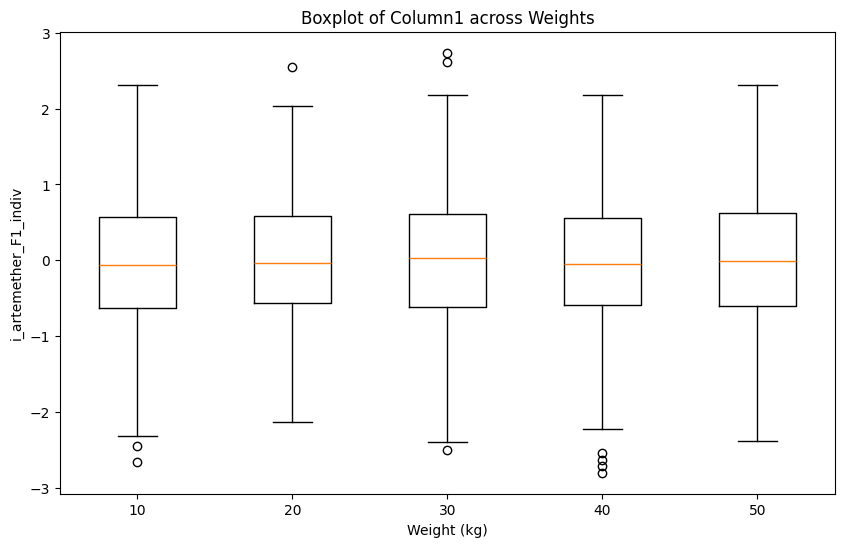

In [ ]:
data_for_boxplot = [pk_params_dfs_artemether[i]["i_artemether_F1_indiv"] for i in range(len(pk_params_dfs_artemether))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('i_artemether_F1_indiv')
plt.title('Boxplot of i_artemether_F1_indiv across Weights')

plt.show()


/tmp/ipykernel_9693/3631346500.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


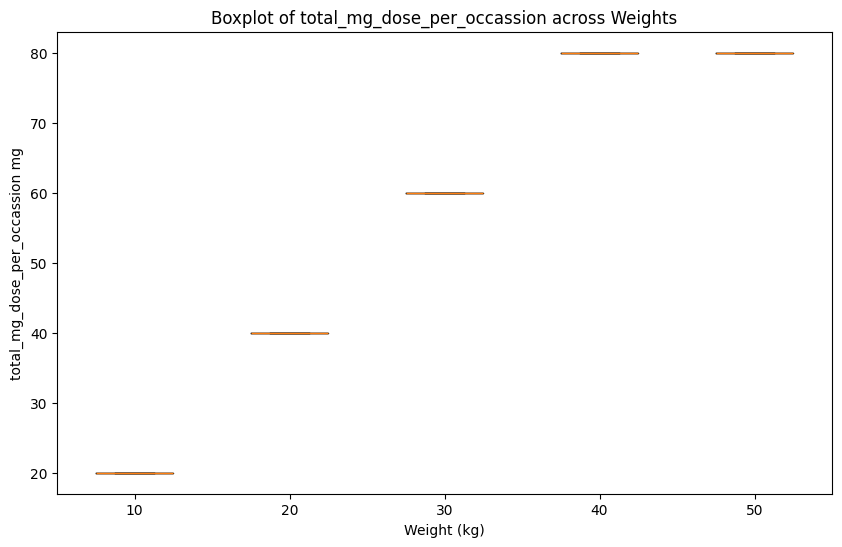

In [45]:
data_for_boxplot = [pk_params_dfs_artemether[i]["total_mg_dose_per_occassion"] for i in range(len(pk_params_dfs_artemether))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('total_mg_dose_per_occassion mg')
plt.title('Boxplot of total_mg_dose_per_occassion across Weights')

plt.show()


/tmp/ipykernel_9693/2309825299.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


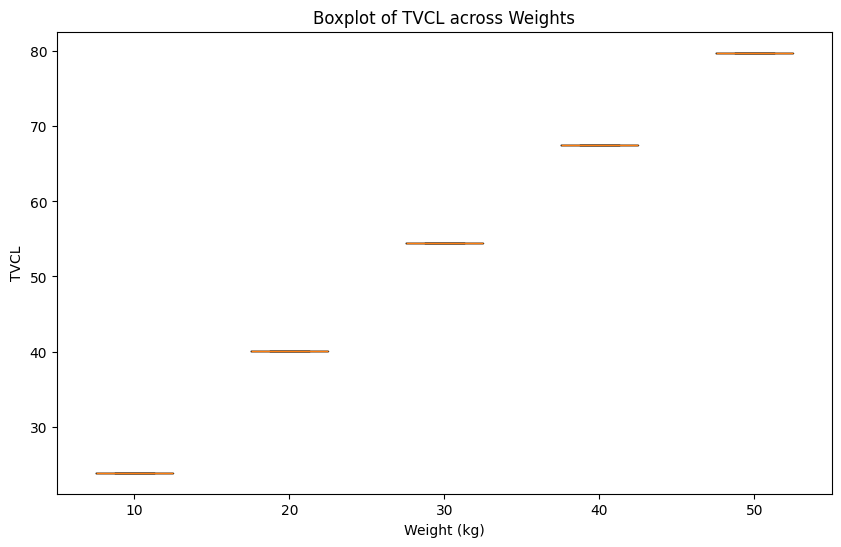

In [48]:
data_for_boxplot = [pk_params_dfs_artemether[i]["TVCL"] for i in range(len(pk_params_dfs_artemether))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('TVCL')
plt.title('Boxplot of TVCL across Weights')

plt.savefig("TVCL_boxplot_artemether_01.png")
plt.show()


/tmp/ipykernel_9693/905276580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


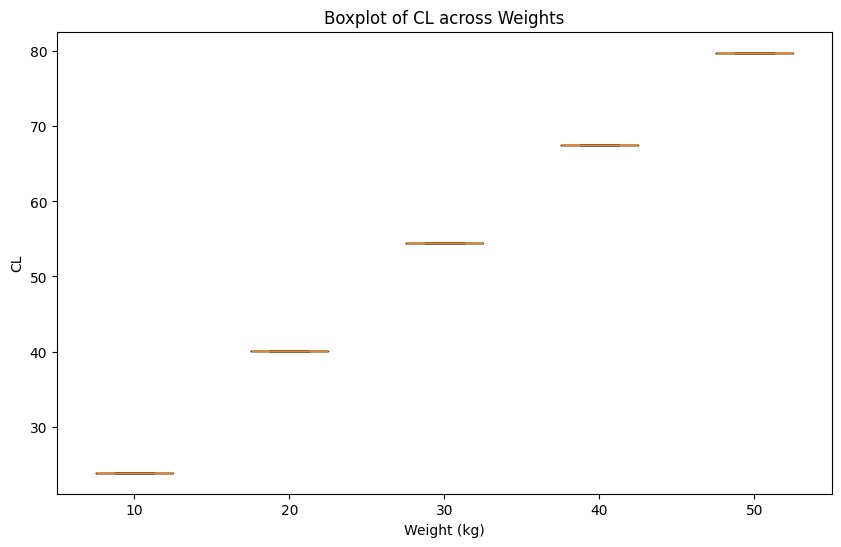

In [49]:
data_for_boxplot = [pk_params_dfs_artemether[i]["CL"] for i in range(len(pk_params_dfs_artemether))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('CL')
plt.title('Boxplot of CL across Weights')

plt.savefig("CL_boxplot_artemether_01.png")
plt.show()


/tmp/ipykernel_9693/2126833572.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


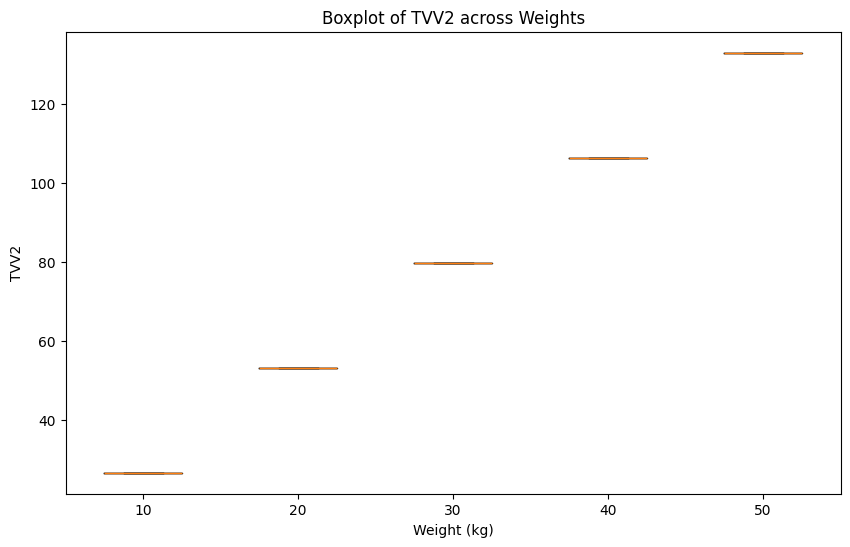

In [50]:
data_for_boxplot = [pk_params_dfs_artemether[i]["TVV2"] for i in range(len(pk_params_dfs_artemether))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('TVV2')
plt.title('Boxplot of TVV2 across Weights')

plt.savefig("TVV2_boxplot_artemether_01.png")
plt.show()


/tmp/ipykernel_9693/2390609497.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


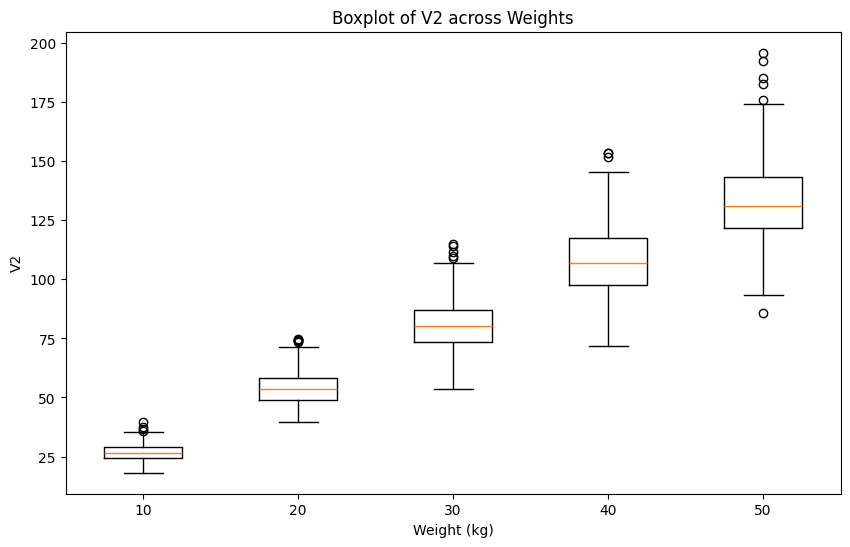

In [51]:
data_for_boxplot = [pk_params_dfs_artemether[i]["V2"] for i in range(len(pk_params_dfs_artemether))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('V2')
plt.title('Boxplot of V2 across Weights')

plt.savefig("V2_boxplot_artemether_01.png")
plt.show()


/tmp/ipykernel_9693/2828573506.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


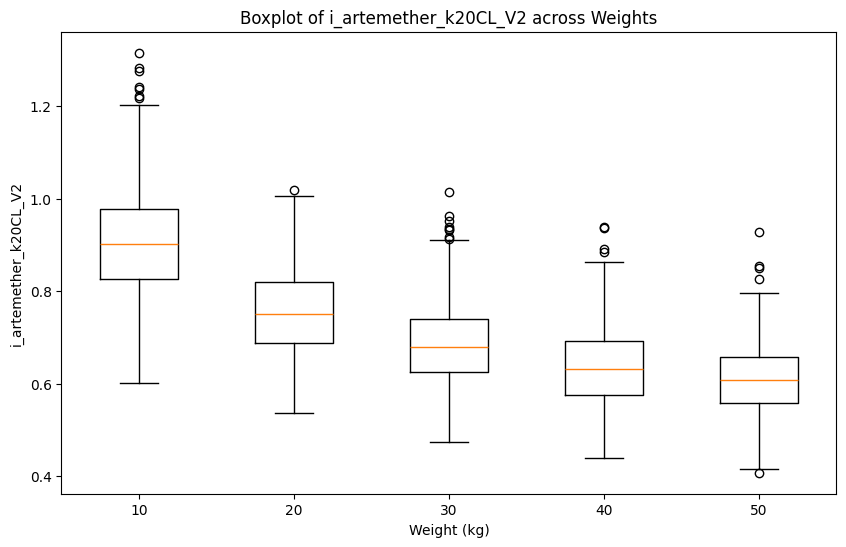

In [52]:
data_for_boxplot = [pk_params_dfs_artemether[i]["i_artemether_k20CL_V2"] for i in range(len(pk_params_dfs_artemether))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('i_artemether_k20CL_V2')
plt.title('Boxplot of i_artemether_k20CL_V2 across Weights')

plt.savefig("i_artemether_k20CL_V2_boxplot_artemether_01.png")
plt.show()


In [74]:
pk_params_dfs_lumefantrine[0].columns

Index(['PID', 'i_lum_F1_indiv', 'i_lum_k12(KA)', 'i_lum_k23(Q_V)',
       'i_lum_k32(Q_VP)', 'i_lum_k20(CL_V)', 'total_mg_dose_per_occassion',
       'DS', 'Q', 'V', 'CL', 'VP'],
      dtype='object')

/tmp/ipykernel_9693/1726105695.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


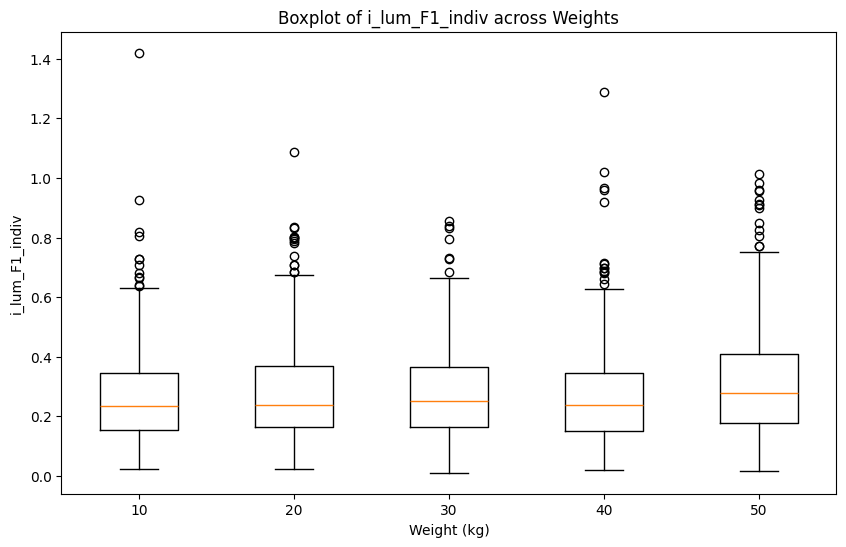

In [75]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["i_lum_F1_indiv"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('i_lum_F1_indiv')
plt.title('Boxplot of i_lum_F1_indiv across Weights')

plt.savefig("i_lum_F1_indiv_boxplot_lumefantrine_01.png")
plt.show()


/tmp/ipykernel_9693/1471703608.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


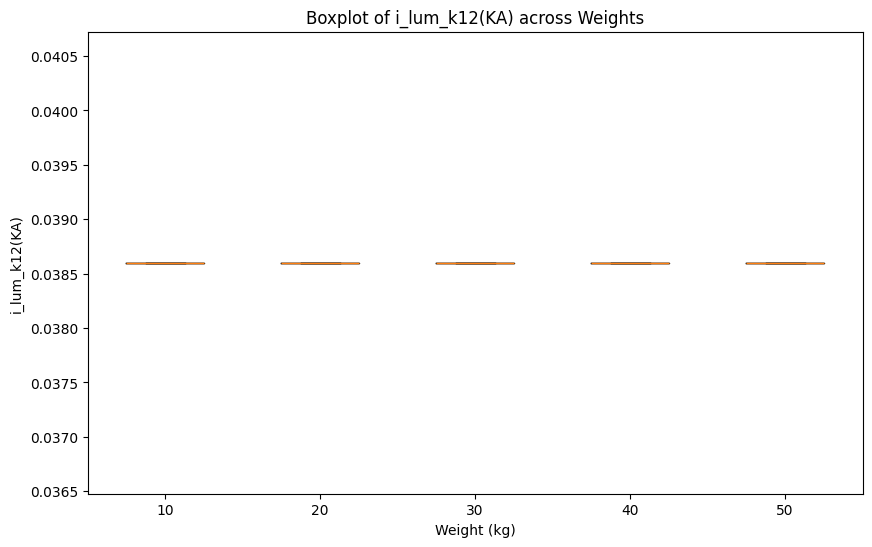

In [76]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["i_lum_k12(KA)"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('i_lum_k12(KA)')
plt.title('Boxplot of i_lum_k12(KA) across Weights')

plt.savefig("i_lum_k12(KA)_boxplot_lumefantrine_01.png")
plt.show()


/tmp/ipykernel_9693/2594267847.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


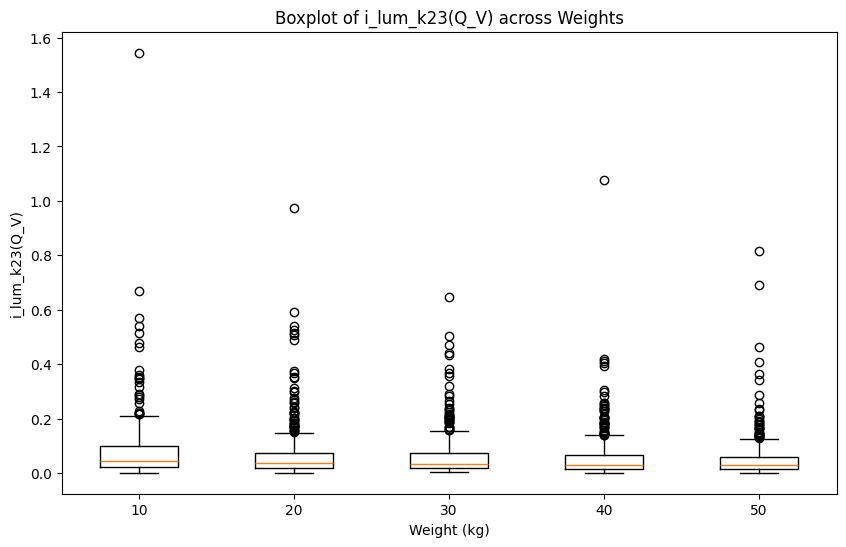

In [77]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["i_lum_k23(Q_V)"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('i_lum_k23(Q_V)')
plt.title('Boxplot of i_lum_k23(Q_V) across Weights')

plt.savefig("i_lum_k23(Q_V)_boxplot_lumefantrine_01.png")
plt.show()


/tmp/ipykernel_9693/3590812113.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


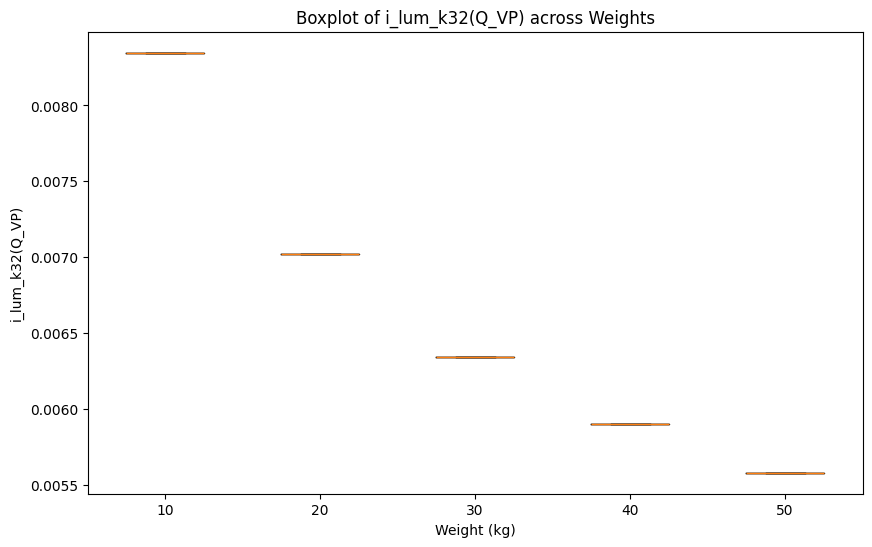

In [78]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["i_lum_k32(Q_VP)"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('i_lum_k32(Q_VP)')
plt.title('Boxplot of i_lum_k32(Q_VP) across Weights')

plt.savefig("i_lum_k32(Q_VP)_boxplot_lumefantrine_01.png")
plt.show()


/tmp/ipykernel_9693/3259185610.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


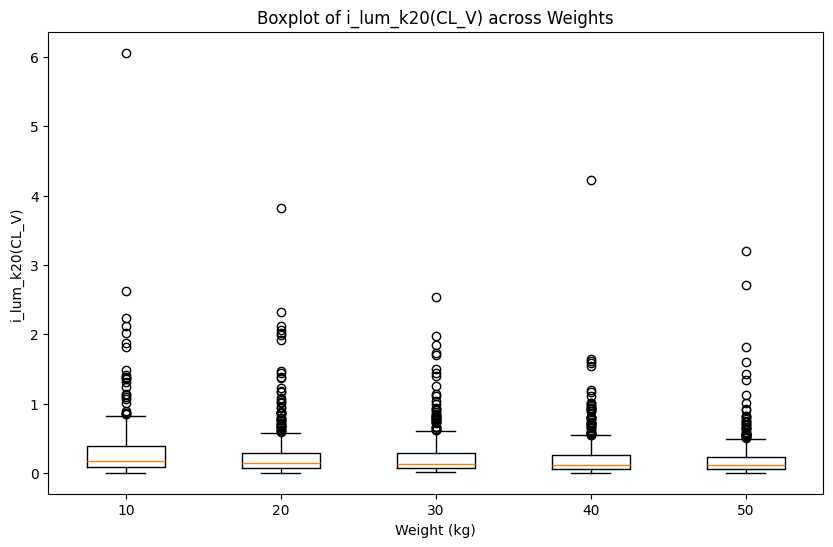

In [79]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["i_lum_k20(CL_V)"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('i_lum_k20(CL_V)')
plt.title('Boxplot of i_lum_k20(CL_V) across Weights')

plt.savefig("i_lum_k20(CL_V)_boxplot_lumefantrine_01.png")
plt.show()


/tmp/ipykernel_9693/425834703.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


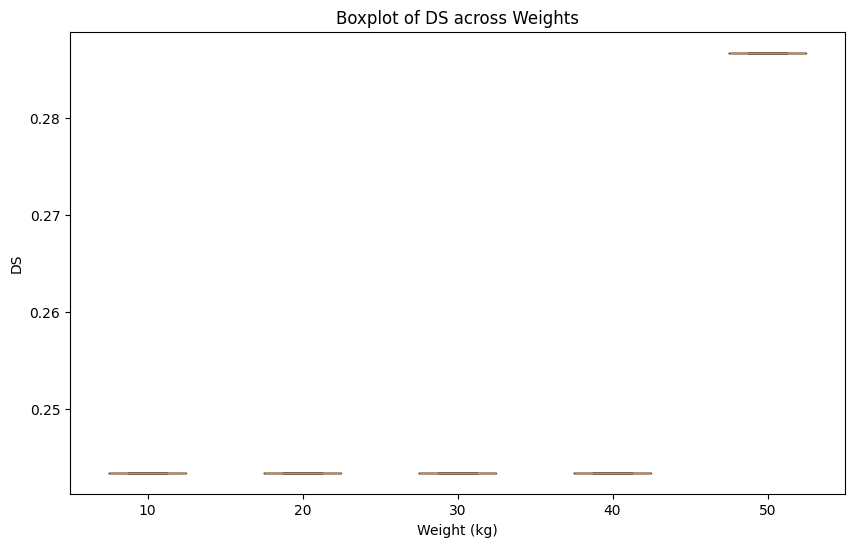

In [81]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["DS"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('DS')
plt.title('Boxplot of DS across Weights')

plt.savefig("DS_boxplot_lumefantrine_01.png")
plt.show()


In [60]:
pk_params_dfs_lumefantrine[0].columns

Index(['PID', 'i_lum_F1_indiv', 'i_lum_k12(KA)', 'i_lum_k23(Q_V)',
       'i_lum_k32(Q_VP)', 'i_lum_k20(CL_V)', 'total_mg_dose_per_occassion',
       'DS', 'Q', 'V', 'CL', 'VP'],
      dtype='object')

/tmp/ipykernel_9693/2742218971.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


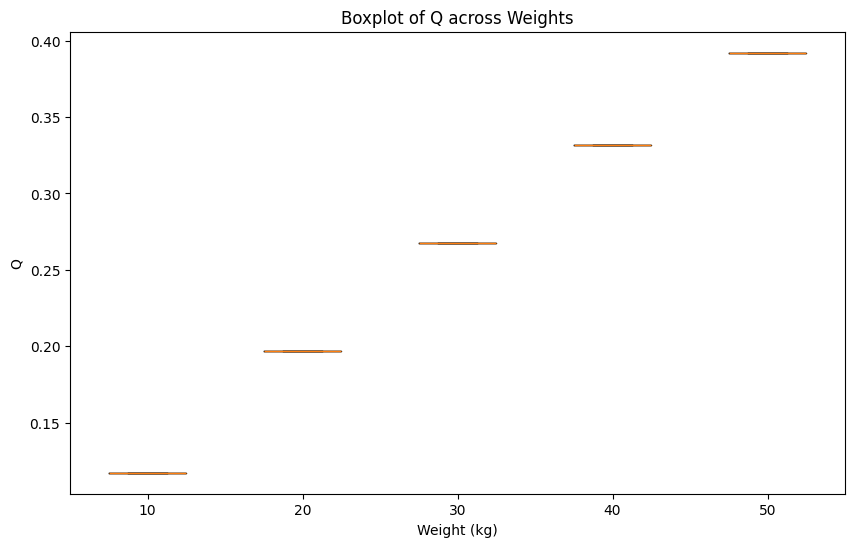

In [82]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["Q"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('Q')
plt.title('Boxplot of Q across Weights')

plt.savefig("Q_boxplot_lumefantrine_01.png")
plt.show()


/tmp/ipykernel_9693/639271178.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


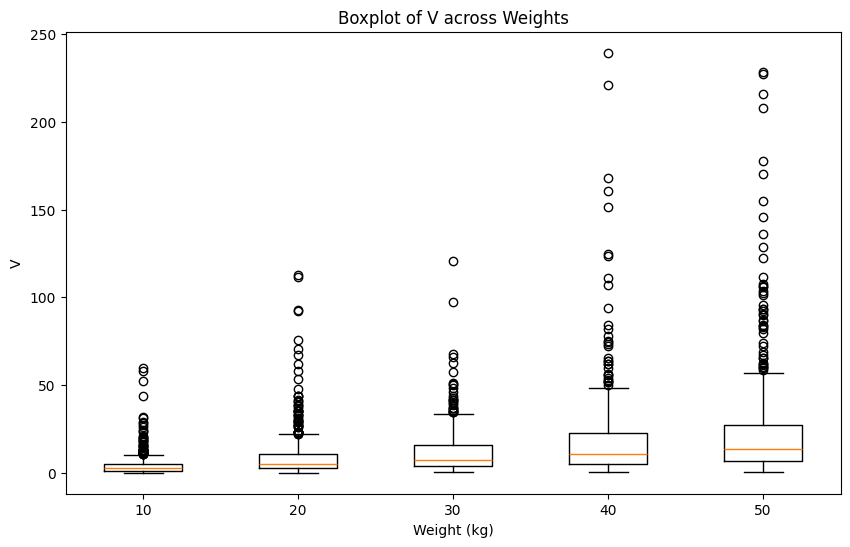

In [83]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["V"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('V')
plt.title('Boxplot of V across Weights')

plt.savefig("V_boxplot_lumefantrine_01.png")
plt.show()


/tmp/ipykernel_9693/1178805296.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


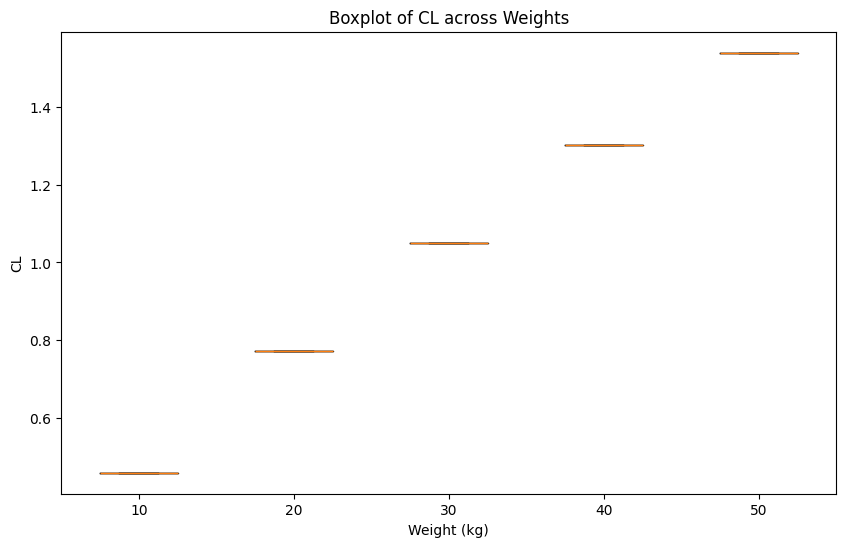

In [84]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["CL"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('CL')
plt.title('Boxplot of CL across Weights')

plt.savefig("CL_boxplot_lumefantrine_01.png")
plt.show()


In [72]:
pk_params_dfs_lumefantrine[0].columns

Index(['PID', 'i_lum_F1_indiv', 'i_lum_k12(KA)', 'i_lum_k23(Q_V)',
       'i_lum_k32(Q_VP)', 'i_lum_k20(CL_V)', 'total_mg_dose_per_occassion',
       'DS', 'Q', 'V', 'CL', 'VP'],
      dtype='object')

/tmp/ipykernel_9693/1284534399.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=weight_labels)


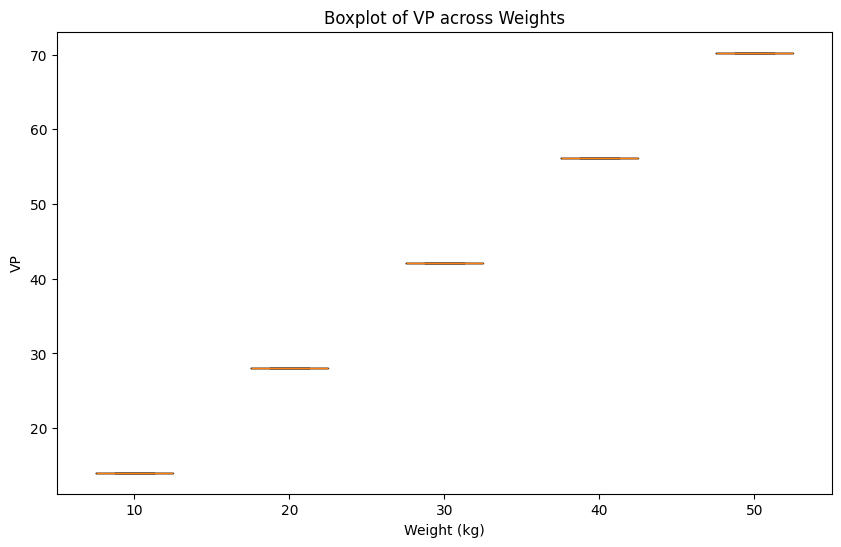

In [85]:
data_for_boxplot = [pk_params_dfs_lumefantrine[i]["VP"] for i in range(len(pk_params_dfs_lumefantrine))]

# Define the weight labels
weight_labels = [10, 20, 30, 40, 50]

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(data_for_boxplot, labels=weight_labels)

# Label the plot
plt.xlabel('Weight (kg)')
plt.ylabel('VP')
plt.title('Boxplot of VP across Weights')

plt.savefig("VP_boxplot_lumefantrine_01.png")
plt.show()
